In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import *
import copy
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

2018-08-27 16:09:04.740 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from src.fewshot_ner_viz_component.data_processing import *
from src.fewshot_ner_viz_component.utils import *
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import *

2018-08-27 16:09:04.819 INFO in 'summarizer.preprocessing.cleaner'['textcleaner'] at line 37: 'pattern' package not found; tag filters are not available for English


In [3]:
dataset_orig = read_data()
ne_type = 'PERSON'
dataset = filter_dataset_by_ne_types(dataset_orig, ne_type)

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [4]:
tf.reset_default_graph()
sess = tf.Session()

In [5]:
class ElmoEmbedder():
    def __init__(self, custom_weights=False, weights: list = [], trainable_cells=False, restore_path:str=None):
        self.custom_weights = custom_weights
        self.weights = weights
        module_path = "https://tfhub.dev/google/elmo/{}".format(1 if trainable_cells else 2)
        self.elmo = hub.Module(module_path, trainable=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        self.sess = sess
        elmo_vars = [v.name for v in tf.trainable_variables()]
        elmo_vars_dict = {v.name: v for v in tf.trainable_variables()}
        if restore_path:
            print('Restoring finetuned ELMo params from {}'.format(restore_path))
            saver = tf.train.Saver(elmo_vars_dict)
            saver.restore(sess, restore_path)
        self.elmo_vars = elmo_vars

    def get_tokens_embeddings(self, tokens_input: list, tokens_length:list=None, res_as_dict=False):
        if not tokens_length:
            if isinstance(tokens_input[0], list):
                tokens_length = [len(seq) for seq in tokens_input]
            else:
                tokens_length = len(tokens_input)
        elmo_res = self.elmo(
                        inputs={
                            "tokens": tokens_input,
                            "sequence_len": tokens_length
                        },
                        signature="tokens",
                        as_dict=True)
        embeddings_sum = elmo_res["elmo"]
        word_emb = elmo_res["word_emb"]
        embeddings_layer1 = elmo_res["lstm_outputs1"]
        embeddings_layer2 = elmo_res["lstm_outputs2"]
        embeddings_sum, word_emb, embeddings_layer1, embeddings_layer2 = self.sess.run([embeddings_sum, word_emb, embeddings_layer1, embeddings_layer2])
        word_emb = np.concatenate((word_emb, word_emb), axis=-1)
        if res_as_dict:
            return {'word': word_emb, 'layer1': embeddings_layer1, 'layer2': embeddings_layer2}
        # print(embeddings_sum.shape)
        # print(embeddings_layer1.shape)
        # print(embeddings_layer2.shape)
        embeddings = embeddings_sum
        if self.custom_weights:
            if len(self.weights) == 2:
                embeddings = embeddings_layer1*self.weights[0] + embeddings_layer2*self.weights[1]
            elif len(self.weights) == 3:
                embeddings = word_emb*self.weights[0] + embeddings_layer1*self.weights[1] + embeddings_layer2*self.weights[2]
        return embeddings

In [6]:
class CompositeEmbedder():
    def __init__(self, use_elmo=True, elmo_scale=1., cap_scale=1., use_cap_feat=False, use_glove=False, elmo_params={}):
        self.use_elmo = use_elmo
        self.elmo_scale = elmo_scale
        self.cap_scale = cap_scale
        self.use_cap_feat = use_cap_feat
        self.use_glove = use_glove
        if self.use_elmo:
            self.elmo = ElmoEmbedder(**elmo_params)
        if self.use_cap_feat:
            self.cap_prep = CapitalizationPreprocessor()
        if self.use_glove:
            self.glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
        self.embed_size = self.embed(['hehe']).shape[-1]

    def embed(self, tokens: list, res_as_dict=False):
        if isinstance(tokens[0], str):
            tokens = [tokens]
        # Get ELMo embeddings
        if self.use_elmo:
            tokens_input = add_padding(tokens)
            tokens_length = get_tokens_len(tokens)
            elmo_embed = self.elmo.get_tokens_embeddings(tokens_input, tokens_length)
            embeddings = elmo_embed
            embeddings *= self.elmo_scale
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
#             print(embed_size)

        # Use capitalization features
        if self.use_cap_feat:
#             print('Use capitalization features')
            cap_features = self.cap_prep(tokens)*self.cap_scale
    #         print(cap_features)
#             print(cap_features.shape)
            embeddings = np.concatenate((embeddings, cap_features), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)

        # Use GloVe embeddings
        if self.use_glove:
#             print('Use GloVe')

            glove_embed = self.glove(to_lower_case(tokens))
            glove_embed = np.array(glove_embed)
            if not self.use_elmo:
                embeddings = glove_embed
            else:
                embeddings = np.concatenate((embeddings, glove_embed), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)

        if res_as_dict:
            return {'elmo': elmo_embed, 'cap': cap_features, 'glove': glove_embed}
        return embeddings

In [7]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)

In [8]:
# elmo_vars = [v.name for v in tf.trainable_variables()]
# print(elmo_vars)
# elmo_vars_dict = {v.name: v for v in tf.trainable_variables()}
# saver = tf.train.Saver(elmo_vars_dict)
# saver.restore(sess, "./tmp/elmo.ckpt")

In [9]:
embedder2 = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False, elmo_params={'trainable_cells': True, 'restore_path': "./tmp/elmo.ckpt"})

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


2018-08-27 16:09:08.370 INFO in 'tensorflow'['tf_logging'] at line 159: Using /tmp/tfhub_modules to cache modules.


Restoring finetuned ELMo params from ./tmp/elmo.ckpt
INFO:tensorflow:Restoring parameters from ./tmp/elmo.ckpt


2018-08-27 16:09:08.954 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./tmp/elmo.ckpt


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:09.542 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


In [10]:
embedder1 = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False, elmo_params={'trainable_cells': True})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:11.486 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


In [11]:
N_EXAMPLES = 10
N_TEST_SENTENCES = 100
MODELS = ['ne_centroid', 'svm']
MODEL_PARAMS = {'ne_centroid': {'sim_type': 'cosine'},
               'ne_nearest': {'sim_type': 'cosine'},
               'weighted_kNN': {'k': 1, 'metric': 'cosine', 'use_class_weights': False, 'use_sim_weights': True},
               'centroid_kNN': {'k': 10, 'metric': 'dot_prod', 'use_class_weights': False},
               'svm': {}}
USE_CV = False

In [12]:
tokens_train,tags_train = get_data_sample(dataset['train'], N_EXAMPLES)
tokens_test,tags_test = get_data_sample(dataset['test'], min(N_TEST_SENTENCES, len(dataset['test'])))
y_test = np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])
f1_scores = {}
sims = {}
embedder_names = ['Initial', 'Fine_tuned']
for i, embedder in enumerate([embedder1, embedder2]):
    print('Embedder: {}'.format(embedder_names[i]))
    ner_bin_clf = FewshotNerBinaryClassifier(embedder)
    ner_bin_clf.train_on_batch(tokens_train, tags_train)
    results = ner_bin_clf.predict(tokens_test, MODELS, MODEL_PARAMS)
    f1_scores[embedder_names[i]] = {}
    for model in MODELS:
        if results[model].get('sim'):
            sims[embedder_names[i]] = flatten_sim(results[model]['sim'])['cosine']
        pred = results[model]['pred']
        f1 = f1_score(y_test, pred)
        f1_scores[embedder_names[i]][model] = f1

Embedder: Initial
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:12.221 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:13.416 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
SVM classifier model
Embedder: Fine_tuned
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:15.802 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:09:16.845 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
SVM classifier model


In [13]:
print(f1_scores)

{'Initial': {'ne_centroid': 0.7064439140811457, 'svm': 0.875283446712018}, 'Fine_tuned': {'ne_centroid': 0.8483516483516483, 'svm': 0.8798185941043084}}


2018-08-27 16:09:18.770 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-08-27 16:09:18.790 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


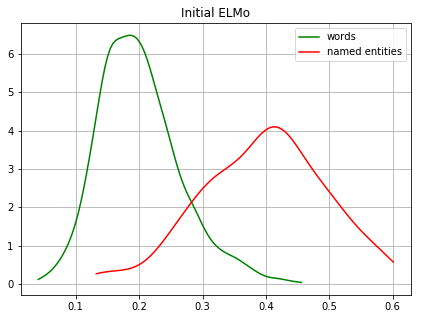

In [14]:
plotPDE(sims[embedder_names[0]], y_test, 'Initial ELMo')

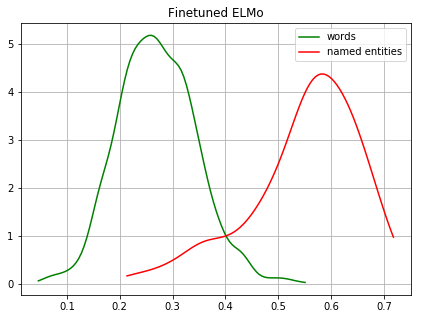

In [15]:
plotPDE(sims[embedder_names[1]], y_test, 'Finetuned ELMo')